In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error,mean_squared_error
import xgboost as xgb
from scipy import stats
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    
    r2_score, mean_absolute_error, mean_squared_error,
    
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

ModuleNotFoundError: No module named 'pandas'

In [5]:
df=pd.read_csv("/Users/harshit/Downloads/log.csv")

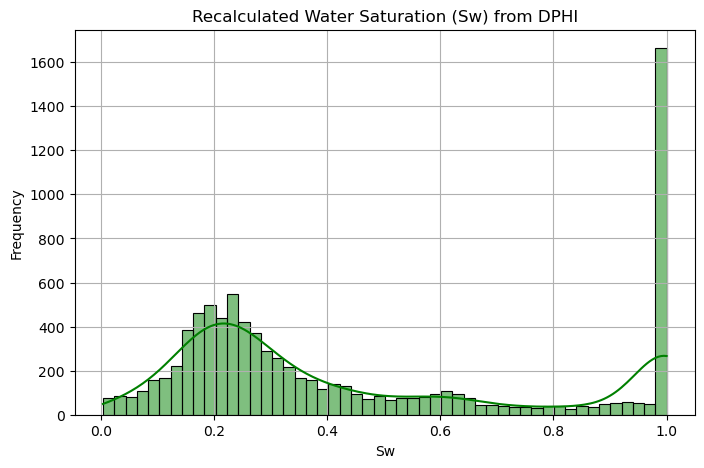

In [7]:
Rw = 0.1  # Formation water resistivity
a, m, n = 1, 2, 2  # Archie's constants

# Calculate porosity from DPHI
df['phi'] = df['DPOR'] / 100  # or just df['dpor'] if it's already in fraction

# Get Rt (resistivity) and handle divide-by-zero safely
Rt = df['RILD'].replace(0, np.nan)

# Apply Archie's equation
df['sw'] = ((a * Rw) / (df['phi'] ** m * Rt)) ** (1 / n)
df['sw'] = df['sw'].clip(0, 1)  # constrain to [0, 1]

# Plot the recalculated Sw
plt.figure(figsize=(8, 5))
sn.histplot(df['sw'], bins=50, kde=True, color='green')
plt.title('Recalculated Water Saturation (Sw) from DPHI')
plt.xlabel('Sw')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [8]:
df_original = df.copy()


In [11]:
print(df.head())

   Depth     RxoRt    RLL3       SP      RILD      MN      MI    MCAL    DCAL  \
0  195.0  226.0848  0.4076  69.8953  132.5052 -0.3548  0.1863  5.1090  1.8878   
1  195.5  223.5031  0.4063  69.2303  123.6225 -0.3619  0.1867  5.1031  1.8882   
2  196.0  221.4560  0.4047  68.4478  116.9258 -0.3668  0.1860  5.0872  1.8878   
3  196.5  219.8248  0.4033  67.4843  111.7925 -0.3613  0.1867  5.0881  1.8884   
4  197.0  218.1438  0.4023  66.3013  106.7821 -0.3569  0.1870  5.0972  1.8883   

     RHOB    RHOC     DPOR     CNLS       GR       phi        sw  
0  1.6973 -0.6303  59.2216  30.0657  60.4576  0.592216  0.046388  
1  1.6791 -0.6409  60.2877  26.7625  54.1495  0.602877  0.047176  
2  1.6585 -0.6539  61.4914  27.6017  51.9944  0.614914  0.047559  
3  1.6435 -0.6649  62.3711  31.5870  52.9645  0.623711  0.047952  
4  1.6390 -0.6705  62.6343  35.8251  54.9659  0.626343  0.048858  


In [13]:
print("Shape of dataset:", df.shape)

Shape of dataset: (8739, 16)


In [15]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8739 entries, 0 to 8738
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Depth   8739 non-null   float64
 1   RxoRt   8739 non-null   float64
 2   RLL3    8739 non-null   float64
 3   SP      8739 non-null   float64
 4   RILD    8739 non-null   float64
 5   MN      8739 non-null   float64
 6   MI      8739 non-null   float64
 7   MCAL    8739 non-null   float64
 8   DCAL    8739 non-null   float64
 9   RHOB    8739 non-null   float64
 10  RHOC    8739 non-null   float64
 11  DPOR    8739 non-null   float64
 12  CNLS    8739 non-null   float64
 13  GR      8739 non-null   float64
 14  phi     8739 non-null   float64
 15  sw      8739 non-null   float64
dtypes: float64(16)
memory usage: 1.1 MB
None


In [17]:
# 📌 Check for missing values in each column
print("Missing values per column:")
print(df.isnull().sum())

# 📌 Check total number of missing values
print("\nTotal missing values:", df.isnull().sum().sum())

# 📌 Check for duplicate rows
print("\nTotal duplicate rows:", df.duplicated().sum())


Missing values per column:
Depth    0
RxoRt    0
RLL3     0
SP       0
RILD     0
MN       0
MI       0
MCAL     0
DCAL     0
RHOB     0
RHOC     0
DPOR     0
CNLS     0
GR       0
phi      0
sw       0
dtype: int64

Total missing values: 0

Total duplicate rows: 0


In [19]:
# Fill numerical columns with median
df.fillna(df.median(numeric_only=True), inplace=True)

# OR: Fill categorical columns with mode
for col in df.select_dtypes(include=['object']).columns:
    df[col].fillna(df[col].mode()[0], inplace=True)


In [21]:
df.drop_duplicates(inplace=True)

In [23]:
basic_info = df.describe()
basic_info

,Depth,RxoRt,RLL3,SP,RILD,MN,MI,MCAL,DCAL,RHOB,RHOC,DPOR,CNLS,GR,phi,sw
count,8739.000000,8739.000000,8739.000000,8739.000000,8739.000000,8739.000000,8739.000000,8739.000000,8739.000000,8739.00000,8739.000000,8739.0000,8739.000000,8739.000000,8739.000000,8739.000000
mean,2535.727372,-18.493591,37.948919,-94.299762,34.511874,11.714442,12.180632,5.906369,3.669944,2.03364,0.126320,39.5532,20.129247,76.948923,0.395532,0.455538
std,1358.246302,31.420924,81.734581,39.652558,251.238360,27.537012,28.874862,1.305561,2.748873,0.41571,0.103907,24.3105,11.427909,33.859411,0.243105,0.327426
min,195.000000,-150.821900,0.389900,-201.623000,0.210400,-0.527400,-0.673500,5.047400,1.885300,1.19050,-0.670500,-1.8873,-0.513900,0.005800,-0.018873,0.003483
25%,1292.250000,-31.993950,6.430800,-131.421100,4.356500,0.306700,0.097650,5.089800,1.919350,1.68905,0.049600,14.8416,8.888250,52.336950,0.148416,0.200088
50%,2623.500000,-16.509300,12.138400,-95.587500,7.822900,0.970300,0.361700,5.098500,1.977500,2.00030,0.109800,41.5051,21.053800,77.034000,0.415051,0.307591
75%,3715.750000,-5.941450,25.696300,-58.054000,19.486800,7.978100,7.307150,7.764550,7.850000,2.45620,0.210100,59.7036,29.544100,96.306700,0.597036,0.729366
max,4808.000000,247.583200,880.859400,69.895300,11510.641600,252.124200,234.871500,10.308600,12.334900,2.74230,0.357500,88.8601,47.581000,404.288100,0.888601,1.000000


In [25]:
print("Shape of dataset:", df.shape)

Shape of dataset: (8739, 16)


In [27]:
z_scores = stats.zscore(df.select_dtypes(include='number'))
df = df[(abs(z_scores) < 3).all(axis=1)]

In [29]:
#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(df[['ILD', 'GR', 'DEPTH']])

In [31]:
sn.set(style="whitegrid")

# Basic info


# Check for missing values
missing_values = df.isnull().sum()


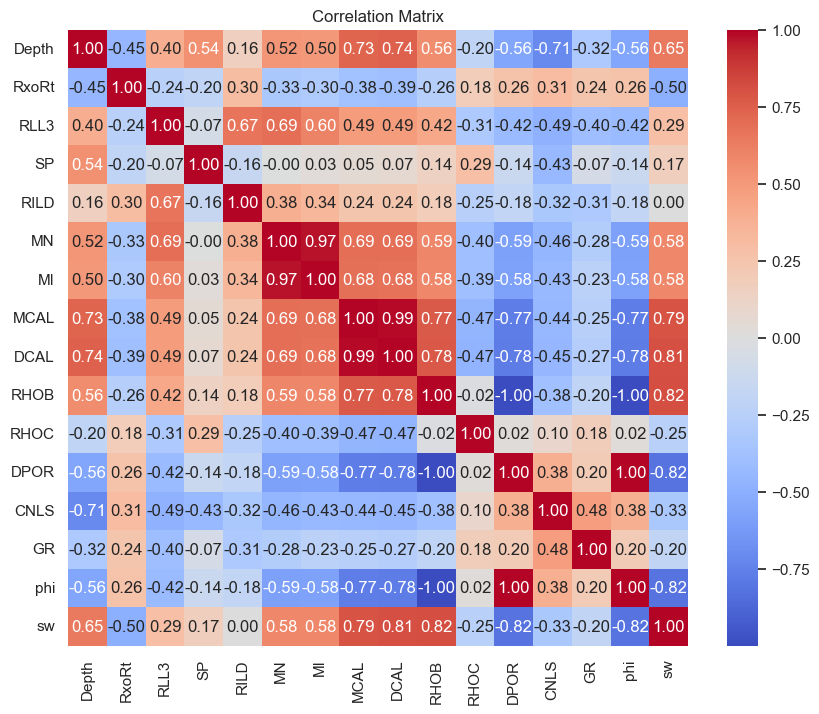

In [33]:
plt.figure(figsize=(10, 8))
sn.heatmap(df.corr(),annot=True ,fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [35]:
df = df.drop(['SP', 'MI','MCAL'], axis=1)

In [37]:
df = df.drop(['DCAL'], axis=1)

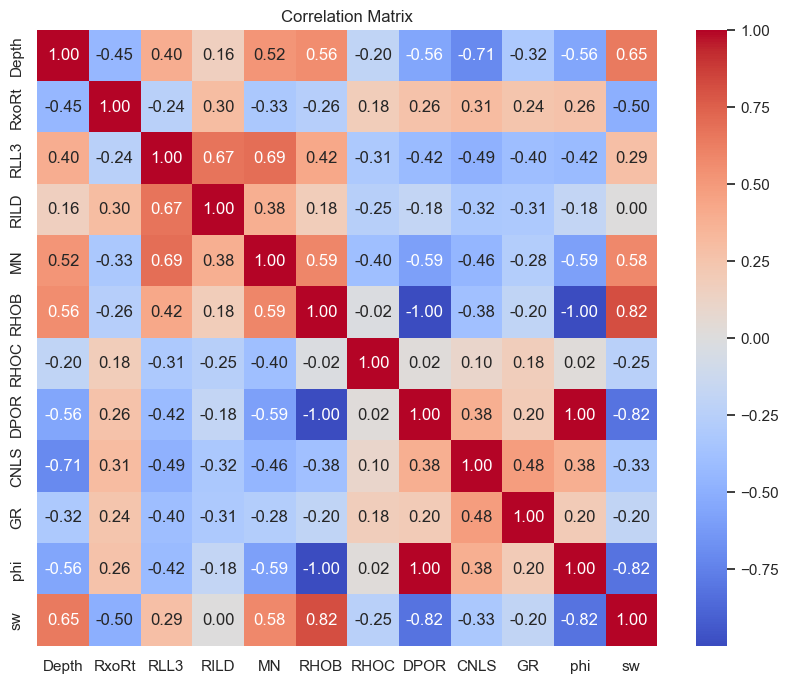

In [39]:
plt.figure(figsize=(10, 8))
sn.heatmap(df.corr(),annot=True ,fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

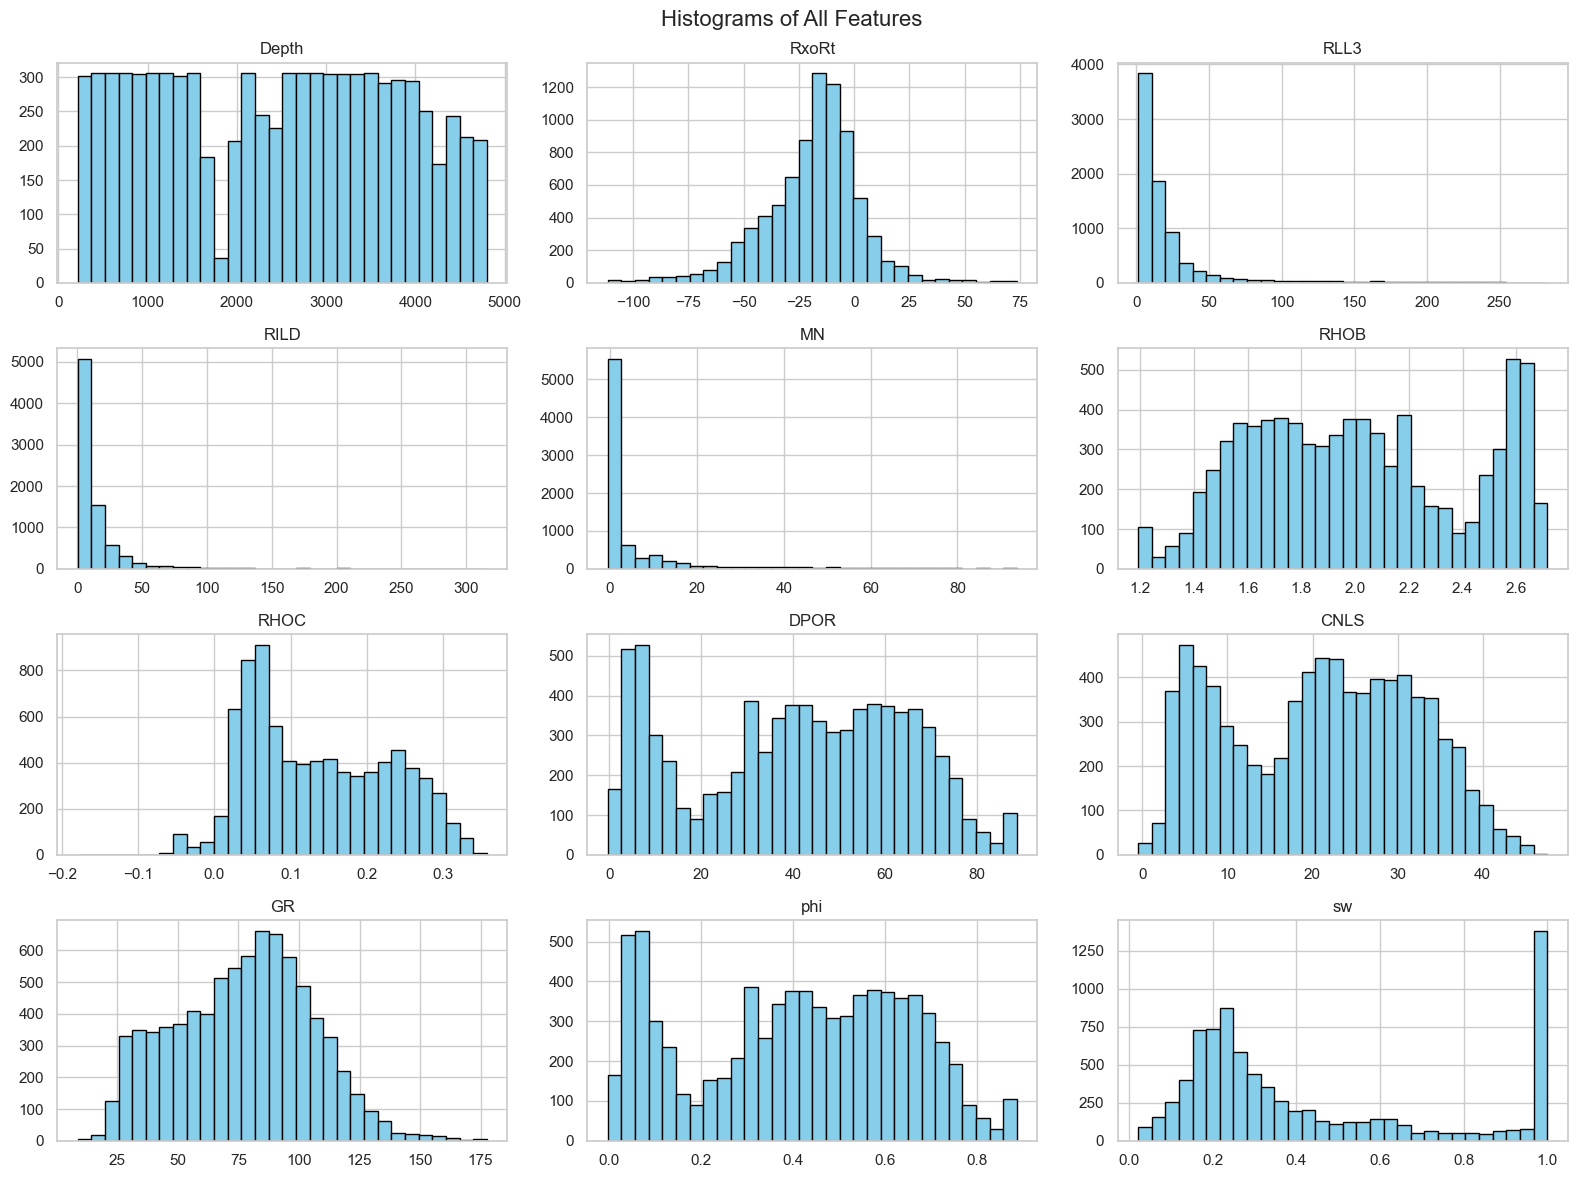

In [41]:
df.hist(figsize=(16, 12), bins=30, color='skyblue', edgecolor='black')
plt.suptitle("Histograms of All Features", fontsize=16)
plt.tight_layout()
plt.show()


In [43]:
df = df.drop(['RHOB'], axis=1)

✅ No outliers found in 'Depth'


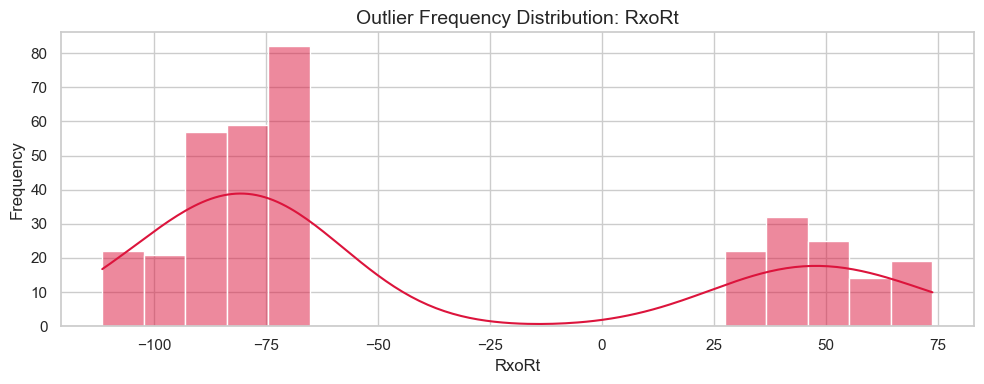

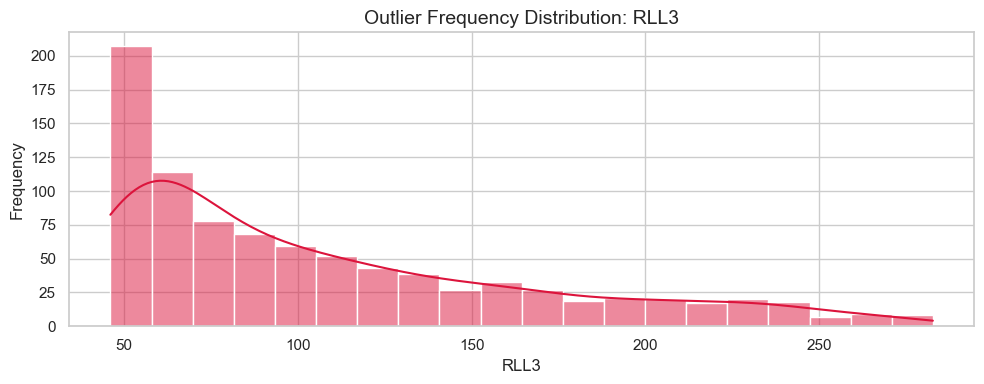

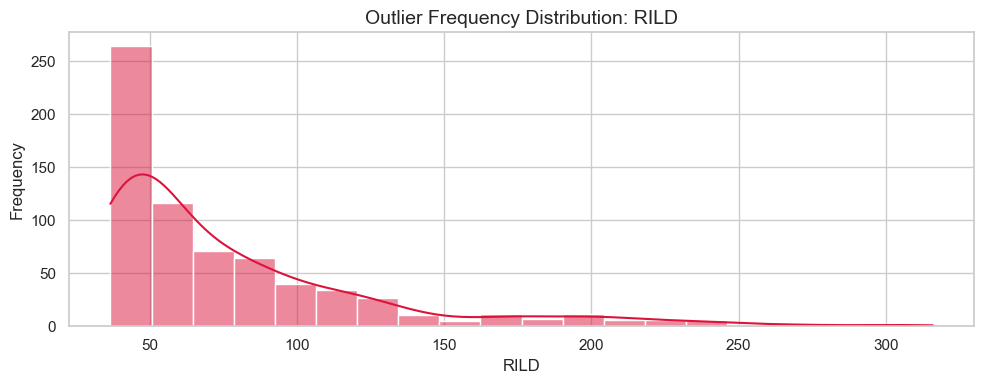

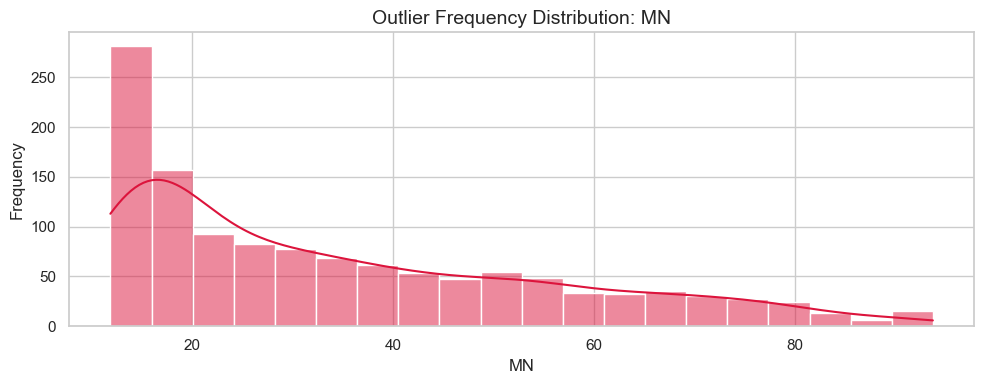

✅ No outliers found in 'RHOC'
✅ No outliers found in 'DPOR'
✅ No outliers found in 'CNLS'


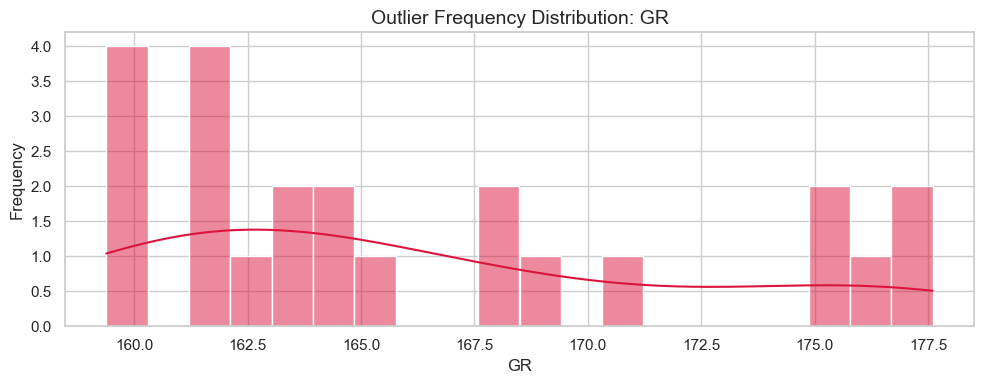

✅ No outliers found in 'phi'
✅ No outliers found in 'sw'


In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set(style="whitegrid")

# Loop through all numeric columns
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    
    # Step 1: Calculate IQR bounds
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Step 2: Identify outliers
    outlier_mask = (df[col] < lower_bound) | (df[col] > upper_bound)
    outliers = df.loc[outlier_mask, col]

    # Step 3: Only plot if outliers are found
    if not outliers.empty:
        plt.figure(figsize=(10, 4))
        sns.histplot(outliers, bins=20, kde=True, color='crimson')
        plt.title(f'Outlier Frequency Distribution: {col}', fontsize=14)
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()
    else:
        print(f"✅ No outliers found in '{col}'")


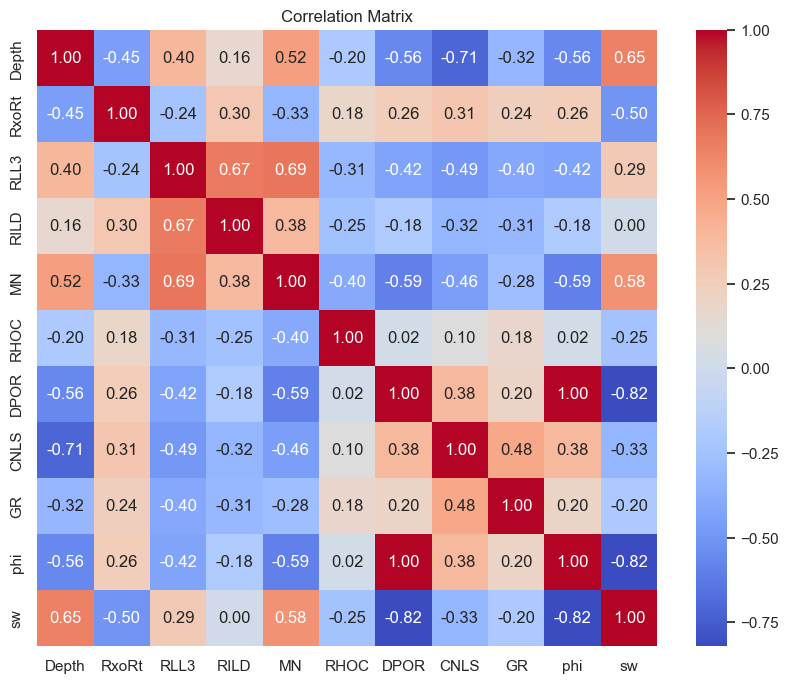

In [49]:
 
numeric_df = df.select_dtypes(include=['number'])

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sn.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [51]:
df = df.drop([ 'DPOR' ], axis=1)

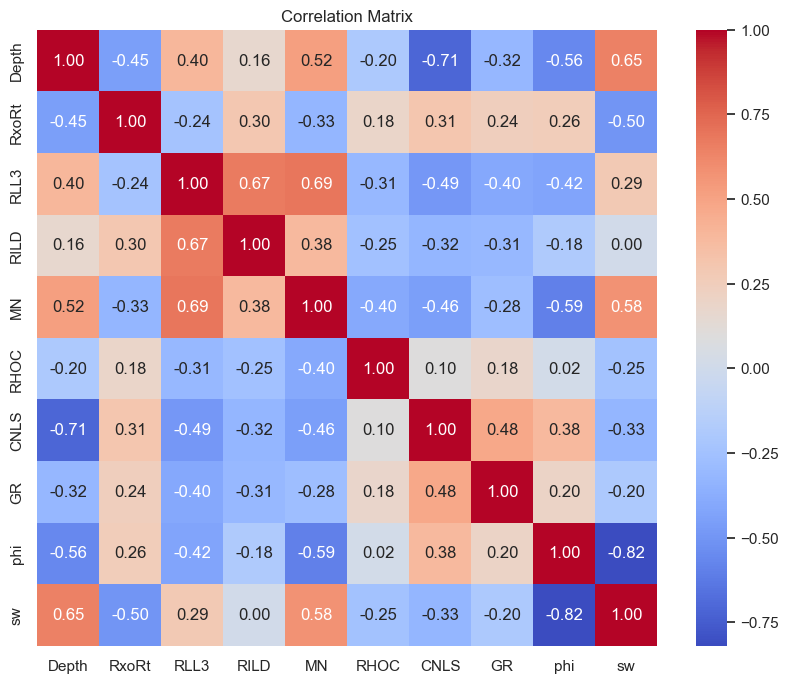

In [53]:
plt.figure(figsize=(10, 8))
sn.heatmap(df.corr(),annot=True ,fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

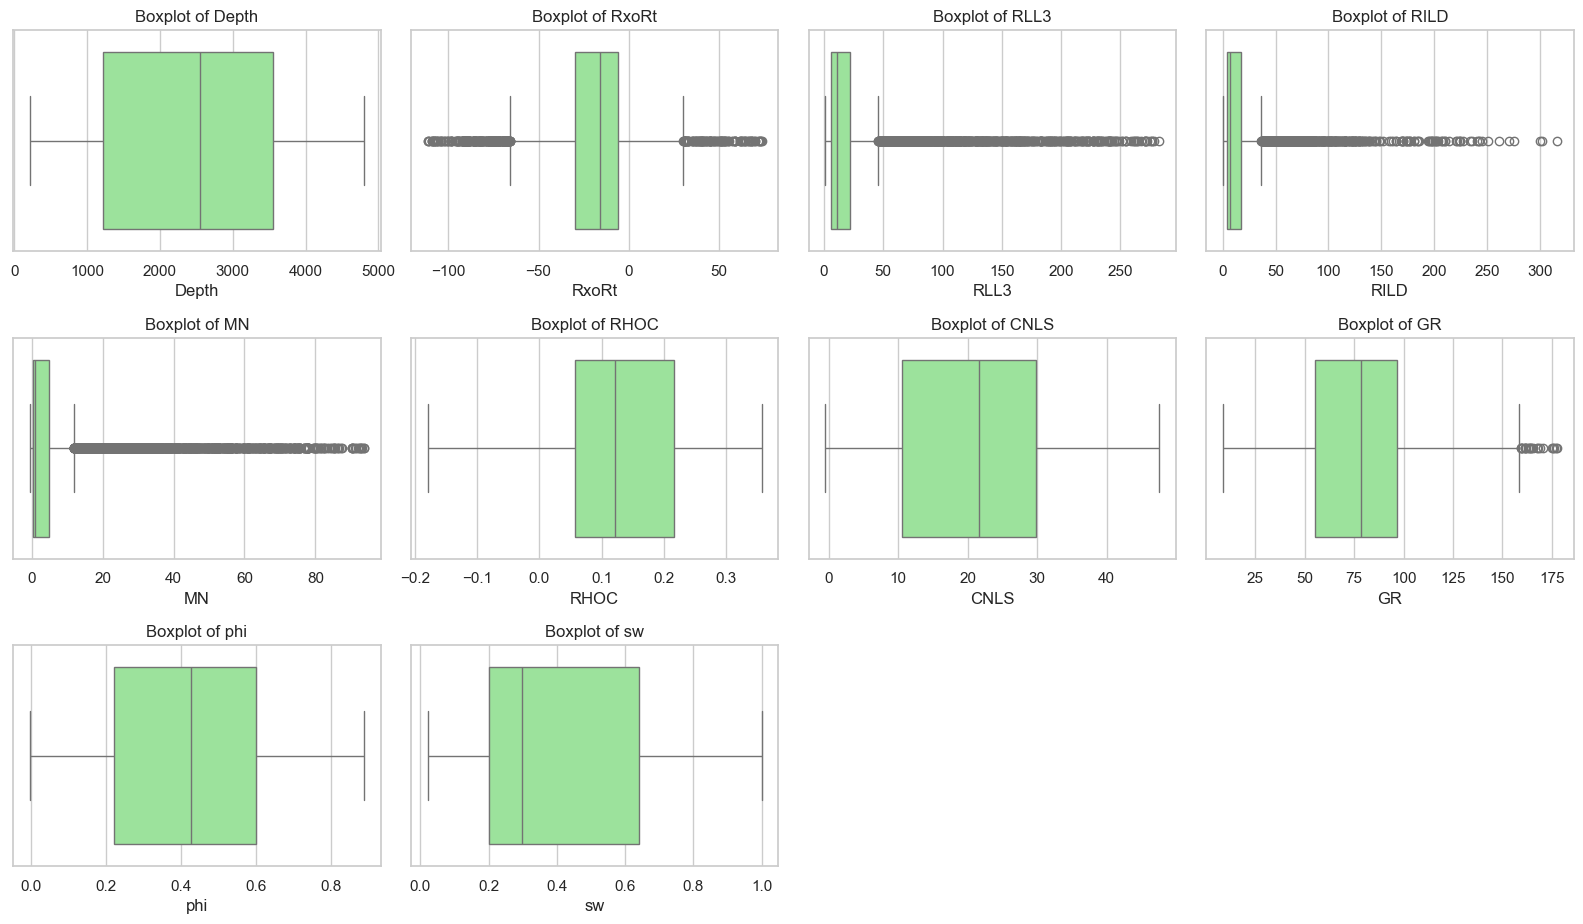

In [128]:
plt.figure(figsize=(16, 12))
for i, col in enumerate(df.columns):
    plt.subplot(4, 4, i + 1)
    sn.boxplot(x=df[col], color='lightgreen')
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()


🔁 Starting Local Median Replacement...
Iteration 1...
Iteration 2...
Iteration 3...
Iteration 4...
Iteration 5...
✅ Local Median Replacement done.
📉 Applying Global Winsorization...
✅ Winsorization complete.
📊 Generating boxplots...


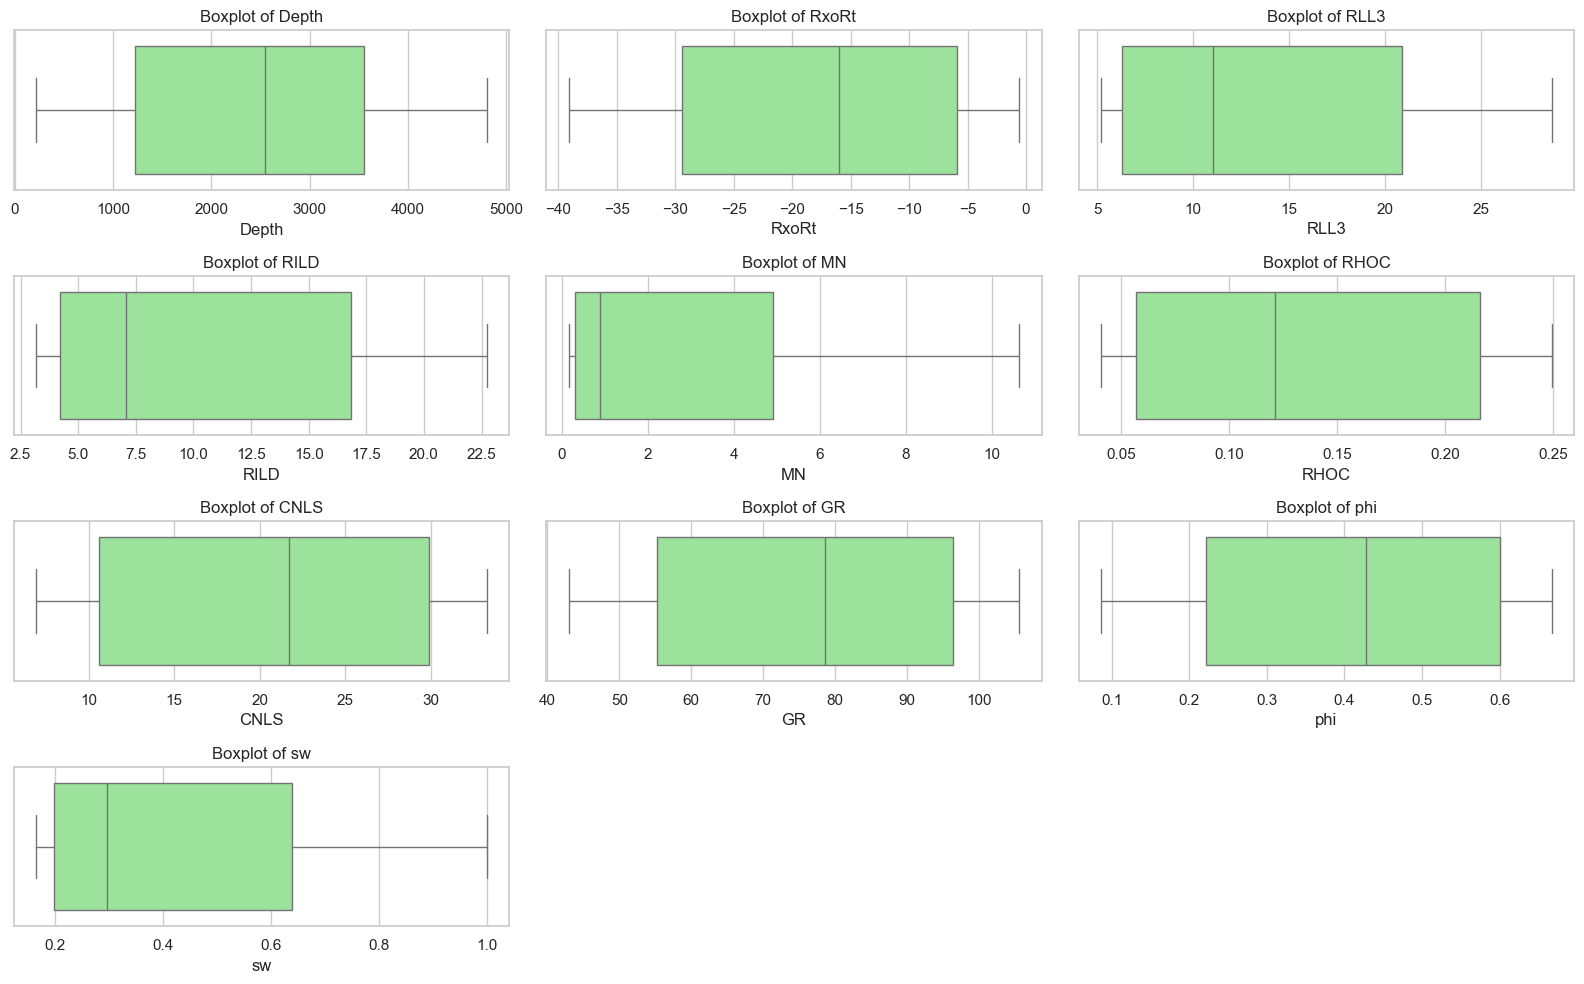

In [55]:

from scipy.stats.mstats import winsorize

import warnings

# Suppress masked array warnings
warnings.filterwarnings("ignore", message=".*partition.*MaskedArray.*")

# Load dataset # Update path if needed
cleaned_df = df.copy()

# Set parameters
depth_window = 10 # 5 ft window centered at the current depth
min_neighbors = 5   # Minimum points in the window to consider replacement
max_iterations = 5  # Number of iterations to apply local median smoothing
winsor_limits = (0.15, 0.15)  # 10% winsorization on both tails

# Select measurement columns (excluding Depth)
measurement_cols = df.columns.drop("Depth")

# Step 1: Local Median Replacement of Outliers
print("🔁 Starting Local Median Replacement...")
for iteration in range(max_iterations):
    print(f"Iteration {iteration + 1}...")
    for col in measurement_cols:
        Q1 = cleaned_df[col].quantile(0.25)
        Q3 = cleaned_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outlier_mask = (cleaned_df[col] < lower_bound) | (cleaned_df[col] > upper_bound)
        for i in cleaned_df[outlier_mask].index:
            depth_i = cleaned_df.at[i, 'Depth']
            window_mask = (
                (cleaned_df['Depth'] >= depth_i - depth_window) &
                (cleaned_df['Depth'] <= depth_i + depth_window) &
                (cleaned_df.index != i)
            )
            window_values = cleaned_df.loc[window_mask, col]
            if window_values.notna().sum() >= min_neighbors:
                cleaned_df.at[i, col] = window_values.median()
print("✅ Local Median Replacement done.")

# Step 2: Global Winsorization to handle residual outliers
print("📉 Applying Global Winsorization...")
for col in measurement_cols:
    cleaned_df[col] = winsorize(cleaned_df[col], limits=winsor_limits)
print("✅ Winsorization complete.")

# Step 3: Plot boxplots for visual inspection
print("📊 Generating boxplots...")
plt.figure(figsize=(16, 10))
for i, col in enumerate(cleaned_df.columns):
    plt.subplot(4, 3, i + 1)
    sn.boxplot(x=cleaned_df[col], color='lightgreen')
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()


In [58]:
df.head()

,Depth,RxoRt,RLL3,RILD,MN,RHOC,CNLS,GR,phi,sw
33,215.0,-0.6440,2.6993,4.3509,0.3789,-0.1796,37.2602,87.1963,0.625710,0.242291
34,215.5,-19.6463,6.4559,4.3716,0.5145,-0.0636,38.6932,87.3085,0.647792,0.233477
35,216.0,-33.4165,11.7076,4.3440,0.5364,0.0105,37.1212,82.1493,0.666936,0.227495
36,216.5,-44.7417,14.6395,4.0274,0.5363,0.0491,36.4796,74.0691,0.681499,0.231218
37,217.0,-50.1247,15.2842,3.9229,0.5380,0.0644,36.9582,68.7614,0.691555,0.230871


In [150]:
X = cleaned_df.drop(columns=['sw', 'phi'])  # All feature columns
y1 = df['sw']
y2 = df['phi']

In [235]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# 🔹 Step 0: Load your DataFrame (df)
# df = pd.read_csv("your_file.csv")  # uncomment if not already loaded

# 🔹 Step 1: First split — 60% train, 40% temp (val + test)
train_df, temp_df = train_test_split(cleaned_df, test_size=0.4, random_state=42)

# 🔹 Step 2: Second split — 50% val, 50% test from the temp (i.e., 20% each of total)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# 🔹 Step 3: Create features and targets
def extract_features_targets(df):
    X = df.drop(columns=['sw', 'phi'])  # Features
    y_sw = df['sw']                      # Target 1
    y_phi = df['phi']                  # Target 2
    return X, y_sw, y_phi

# 🔹 Step 4: Extract for all sets
X_train, y1_train, y2_train = extract_features_targets(train_df)
X_val, y1_val, y2_val = extract_features_targets(val_df)
X_test, y1_test, y2_test = extract_features_targets(test_df)

# 🔹 Step 5: Print split sizes
print(f"Train size     : {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size      : {len(test_df)}")



Train size     : 4834
Validation size: 1611
Test size      : 1612


In [220]:
# Create a deep copy of the validation set
validation_copy = val_df.copy()
val_df['Sw'] = y1_val
val_df['phi'] = y2_val

In [237]:
# Save validation set to CSV
val_df.to_csv("/Users/harshit/Documents/validation_data.csv", index=False)


In [224]:
validation_copy.head()

,Depth,RxoRt,RLL3,RILD,MN,RHOC,CNLS,GR,phi,sw
5826,3352.0,-11.9627,27.7108,19.3916,1.1993,0.2400,6.9202,65.6158,0.428952,0.167411
288,344.0,-0.5695,24.3956,22.7286,0.6309,0.1754,33.2762,97.3017,0.361676,0.172979
2612,1506.0,-17.6435,5.3748,3.5075,3.6080,0.1908,23.1199,105.6374,0.516236,0.327079
7953,4415.5,-39.1178,9.4972,3.1712,10.6465,0.0572,18.2475,48.3401,0.098059,1.000000
6985,3931.5,-39.1178,12.9270,4.4827,10.1559,0.0555,14.8762,51.9465,0.124156,1.000000


In [226]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [228]:
rf_base = RandomForestRegressor(random_state=42)

# Define the hyperparameter space
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(5, 30),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2']
}

In [230]:
rf_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=20,            # Try 20 combinations
    cv=5,                 # 5-fold cross-validation
    scoring='r2',
    verbose=2,
    random_state=42,
    n_jobs=-1             # Use all cores
)


In [232]:
rf_train_sw =rf_search.fit(X_train, y1_train)

best_rf_sw = rf_search.best_estimator_

rf_preds_sw = best_rf_sw.predict(X_test)

ValueError: Found input variables with inconsistent numbers of samples: [8057, 4834]

In [ ]:
print("\n✅ Best Hyperparameters Found:")
print(rf_search.best_params_)


In [168]:
rf_train1_phi =rf_search.fit(X_train, y2_train)
best_rf_phi = rf_search.best_estimator_
rf_preds_phi = best_rf_phi.predict(X_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [169]:
print("\n✅ Best Hyperparameters Found:")
print(rf_search.best_params_)



✅ Best Hyperparameters Found:
{'max_depth': 25, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 160}


In [170]:
def evaluate_model(y_true, y_pred, name):
    print(f"\n📌 Results for {name}")
    print(f"R² Score      : {r2_score(y_true, y_pred):.4f}")
    print(f"RMSE          : {mean_squared_error(y_true, y_pred, squared=False):.4f}")
    print(f"MSE           : {mean_squared_error(y_true, y_pred):.4f}")


In [171]:
evaluate_model(y1_test ,rf_preds_sw , "sw")
evaluate_model(y2_test ,rf_preds_phi, "phi")


📌 Results for sw
R² Score      : 0.9465
RMSE          : 0.0700
MSE           : 0.0049

📌 Results for phi
R² Score      : 0.9860
RMSE          : 0.0246
MSE           : 0.0006


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [172]:
def plot_actual_vs_predicted(y_true, y_pred, target_name="Target"):
    plt.figure(figsize=(8, 6))
    
    # Scatter plot of actual vs predicted
    sn.scatterplot(x=y_true, y=y_pred, color='navy', s=30, label="Predicted vs Actual")

    # Line y = x (perfect prediction)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='Ideal Prediction')
    
    plt.title(f'Actual vs Predicted Values for {target_name}')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

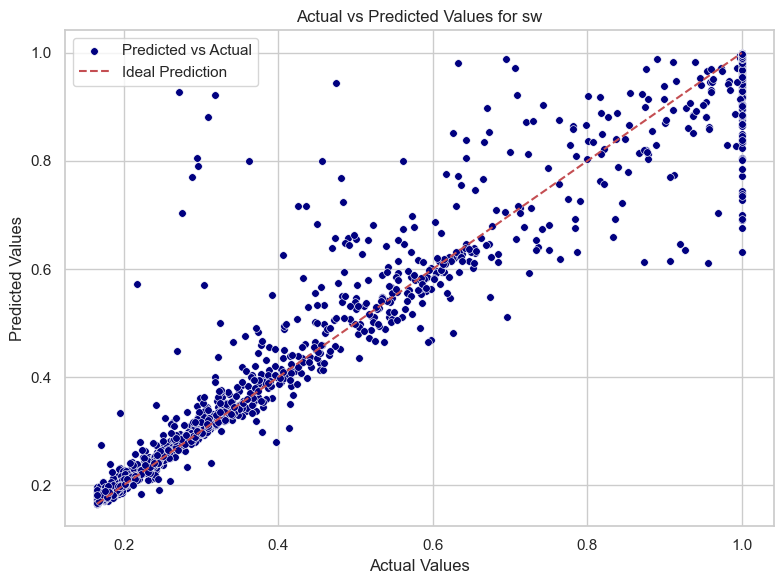

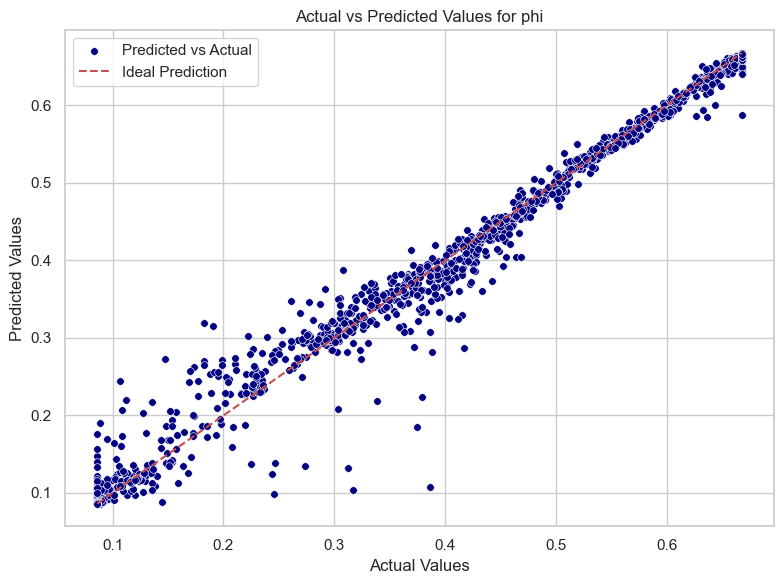

In [173]:
plot_actual_vs_predicted(y1_test, rf_preds_sw, "sw")
plot_actual_vs_predicted(y2_test, rf_preds_phi, "phi")

In [92]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_rf_sw, X_train, y1_train, cv=5, scoring='r2')
print("Cross-validated R² Scores:", cv_scores)
print("Mean R²:", np.mean(cv_scores))

Cross-validated R² Scores: [0.95451189 0.96337615 0.96176402 0.95719589 0.96034254]
Mean R²: 0.9594380968683993


In [93]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_rf_phi, X_train, y2_train, cv=5, scoring='r2')
print("Cross-validated R² Scores:", cv_scores)
print("Mean R²:", np.mean(cv_scores))

Cross-validated R² Scores: [0.98783237 0.99059195 0.99099387 0.98960331 0.99173483]
Mean R²: 0.9901512678405732


In [132]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import randint, uniform

In [134]:
param_grid_xgb = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}


In [136]:
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

xgb_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid_xgb,
    n_iter=100,
    scoring='r2',
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)


In [138]:
xgb_train_sw=xgb_search.fit(X_train, y1_train)
best_xgb_sw = xgb_search.best_estimator_
xgb_preds_sw = best_xgb_sw.predict(X_test)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [139]:
print("\n✅ Best Hyperparameters Found:")
print(xgb_search.best_params_)



✅ Best Hyperparameters Found:
{'colsample_bytree': 0.7970500417163436, 'gamma': 0.056768223837095344, 'learning_rate': 0.1505981925982379, 'max_depth': 4, 'n_estimators': 247, 'reg_alpha': 0.11881791626807192, 'reg_lambda': 0.11752624677710488, 'subsample': 0.8596841208464254}


In [140]:
xgb_train_phi=xgb_search.fit(X_train, y2_train)
best_xgb_phi = xgb_search.best_estimator_
xgb_preds_phi = best_xgb_phi.predict(X_test)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [141]:
print("\n✅ Best Hyperparameters Found:")
print(xgb_search.best_params_)



✅ Best Hyperparameters Found:
{'colsample_bytree': 0.7970500417163436, 'gamma': 0.056768223837095344, 'learning_rate': 0.1505981925982379, 'max_depth': 4, 'n_estimators': 247, 'reg_alpha': 0.11881791626807192, 'reg_lambda': 0.11752624677710488, 'subsample': 0.8596841208464254}


In [146]:
evaluate_model(y1_test ,xgb_preds_sw , "sw")
evaluate_model(y2_test ,xgb_preds_phi, "phi")


📌 Results for sw
R² Score      : 0.9371
RMSE          : 0.0775
MSE           : 0.0060

📌 Results for phi
R² Score      : 0.9756
RMSE          : 0.0362
MSE           : 0.0013


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


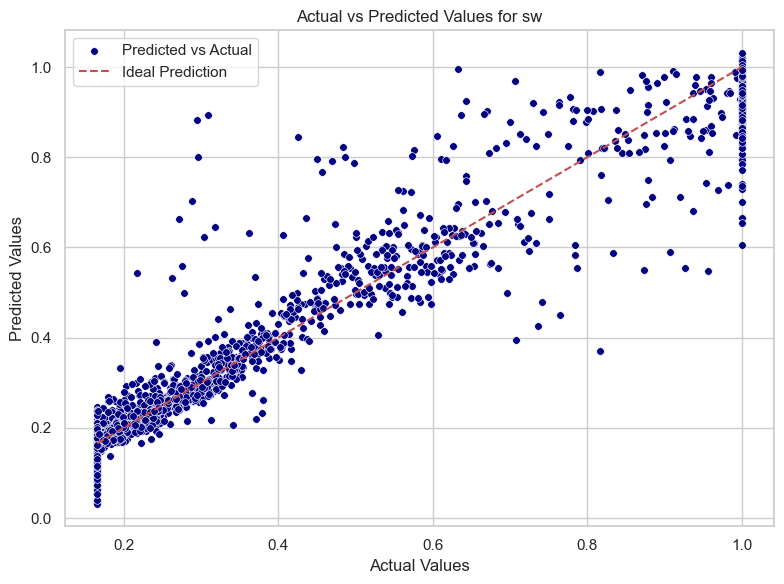

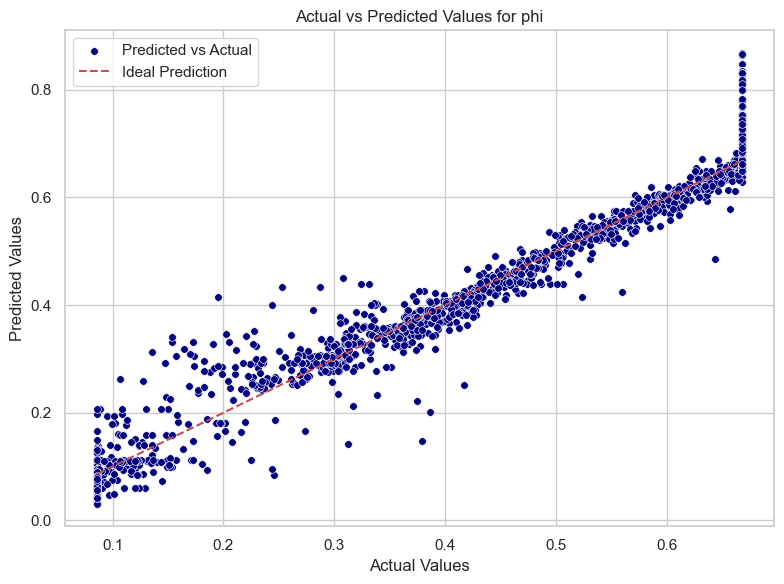

In [184]:
plot_actual_vs_predicted(y1_test, xgb_preds_sw, "sw")
plot_actual_vs_predicted(y2_test,xgb_preds_phi, "phi")

In [186]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_xgb_phi, X_train, y2_train, cv=5, scoring='r2')
print("Cross-validated R² Scores:", cv_scores)
print("Mean R²:", np.mean(cv_scores))

Cross-validated R² Scores: [0.95901523 0.96371915 0.96362295 0.96243497 0.97107538]
Mean R²: 0.9639735365667036


In [188]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

param_grid_knn = {
    'n_neighbors': list(range(1, 31)),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 = Manhattan, 2 = Euclidean
}

In [190]:
#sw model
knn_sw = RandomizedSearchCV(
    estimator=KNeighborsRegressor(),
    param_distributions=param_grid_knn,
    n_iter=50,
    scoring='r2',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
knn_sw.fit(X_train, y1_train)
best_knn_sw = knn_sw.best_estimator_
y1_pred_knn = best_knn_sw.predict(X_test)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [191]:
# DPOR Model
knn_phi = RandomizedSearchCV(
    estimator=KNeighborsRegressor(),
    param_distributions=param_grid_knn,
    n_iter=50,
    scoring='r2',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
knn_phi.fit(X_train, y2_train)
best_knn_phi = knn_phi.best_estimator_
y2_pred_knn = best_knn_phi.predict(X_test)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [192]:
evaluate_model(y1_test, y1_pred_knn, "KNN Saturation Prediction")
evaluate_model(y2_test, y2_pred_knn, "KNN DPOR Prediction")


📌 Results for KNN Saturation Prediction
R² Score      : 0.9725
RMSE          : 0.0502
MSE           : 0.0025

📌 Results for KNN DPOR Prediction
R² Score      : 0.9837
RMSE          : 0.0265
MSE           : 0.0007


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


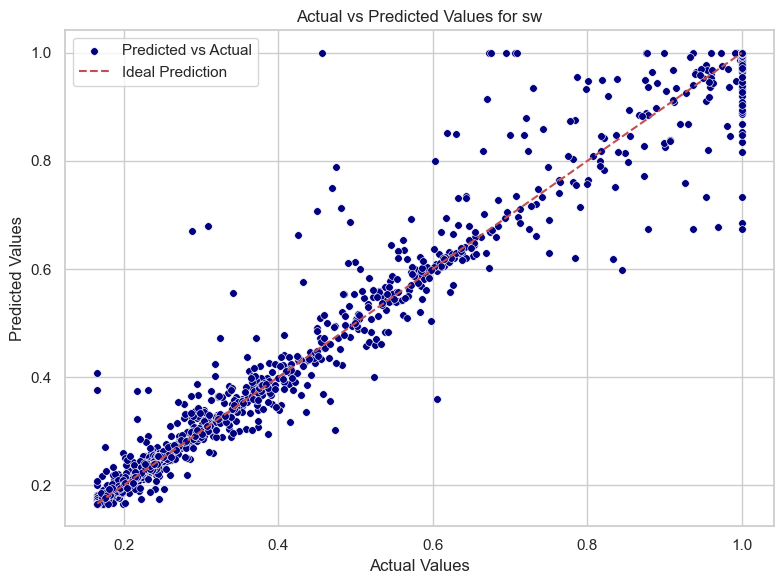

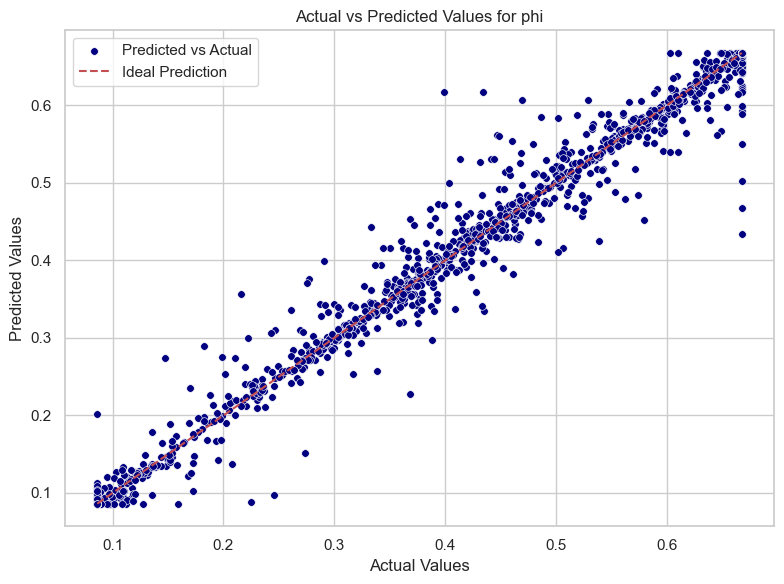

In [214]:
plot_actual_vs_predicted(y1_test, y1_pred_knn, "sw")
plot_actual_vs_predicted(y2_test,y2_pred_knn, "phi")

In [193]:
# Example for saturation (Sw)
'''final_sw_preds = (xgb_preds_sw +  y1_pred_knn) / 2

# For porosity (Φ)
final_DPOR_preds = (xgb_preds_DPOR + y2_pred_knn) / 2'''


'final_sw_preds = (xgb_preds_sw +  y1_pred_knn) / 2\n\n# For porosity (Φ)\nfinal_DPOR_preds = (xgb_preds_DPOR + y2_pred_knn) / 2'

In [ ]:
'''w_xgb=0.5
w_knn=0.5'''

In [ ]:
'''final_sw_preds = (w_xgb * xgb_preds_sw + w_knn * y1_pred_knn)
final_DPOR_preds = (w_xgb * xgb_preds_DPOR +  w_knn * y2_pred_knn)'''

In [ ]:
'''import numpy as np
from sklearn.ensemble import GradientBoostingRegressor

# Stack predictions as features
X_stack_sw = np.column_stack((xgb_preds_sw, y1_pred_knn))
X_stack_DPOR = np.column_stack((xgb_preds_DPOR, y2_pred_knn))

# Train meta-models
meta_model_sw = GradientBoostingRegressor().fit(X_stack_sw, y1_test)
meta_model_DPOR = GradientBoostingRegressor().fit(X_stack_DPOR, y2_test)

# Predict
final_sw_preds = meta_model_sw.predict(X_stack_sw)
final_DPOR_preds = meta_model_DPOR.predict(X_stack_DPOR)'''


In [ ]:
'''from sklearn.metrics import r2_score, mean_squared_error

print("Final Sw R²:", r2_score(y1_test, final_sw_preds))
print("Final Φ R²:", r2_score(y2_test, final_DPOR_preds))'''


In [204]:
import mlflow
import mlflow.sklearn
from sklearn.metrics import r2_score, mean_squared_error

def log_model_with_metrics(model_name, target, best_model, best_params, y_test, y_pred):
    experiment_name = f"{model_name}_{target}_Experiment"
    run_name = f"{model_name}_{target}_Run"

    mlflow.set_experiment(experiment_name)

    with mlflow.start_run(run_name=run_name):
        # Log best hyperparameters
        mlflow.log_params(best_params)

        # Compute and log metrics
        r2 = r2_score(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        mlflow.log_metric("R2", r2)
        mlflow.log_metric("RMSE", rmse)

        # Log model
        model_artifact_name = f"Best_{model_name}_{target}_Model"
        mlflow.sklearn.log_model(best_model, model_artifact_name)

        print(f"✅ Logged {model_name} for {target}: R² = {r2:.4f}, RMSE = {rmse:.4f}")


In [212]:
# XGBoost for Sw
log_model_with_metrics(
    model_name="XGBoost",
    target="Sw",
    best_model=best_xgb_sw,
    best_params=xgb_search.best_params_,
    y_test=y1_test,
    y_pred=xgb_preds_sw
)

# XGBoost for Phi
log_model_with_metrics(
    model_name="XGBoost",
    target="PHI",
    best_model=best_xgb_phi,
    best_params=xgb_search.best_params_,
    y_test=y2_test,
    y_pred=xgb_preds_phi
)

# Random Forest for Sw
log_model_with_metrics(
    model_name="RandomForest",
    target="Sw",
    best_model=best_rf_sw,
    best_params=rf_search.best_params_,
    y_test=y1_test,
    y_pred=rf_preds_sw
)

# Random Forest for Phi
log_model_with_metrics(
    model_name="RandomForest",
    target="PHI",
    best_model=best_rf_phi,
    best_params=rf_search.best_params_,
    y_test=y2_test,
    y_pred=rf_preds_phi
)

# KNN for Sw
log_model_with_metrics(
    model_name="KNN",
    target="Sw",
    best_model=best_knn_sw,
    best_params=knn_sw.best_params_,
    y_test=y1_test,
    y_pred=y1_pred_knn
)

# KNN for Phi
log_model_with_metrics(
    model_name="KNN",
    target="PHI",
    best_model=best_knn_phi,
    best_params=knn_phi.best_params_,
    y_test=y2_test,
    y_pred=y2_pred_knn
)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
2025/06/26 09:47:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


✅ Logged XGBoost for Sw: R² = 0.9309, RMSE = 0.0796
🏃 View run XGBoost_Sw_Run at: http://127.0.0.1:5002/#/experiments/291480824809186921/runs/26321c71ba6547348f702ce9029ec4e7
🧪 View experiment at: http://127.0.0.1:5002/#/experiments/291480824809186921


2025/06/26 09:48:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


✅ Logged XGBoost for PHI: R² = 0.9496, RMSE = 0.0467
🏃 View run XGBoost_PHI_Run at: http://127.0.0.1:5002/#/experiments/726364598991439488/runs/06314ba84c23401993e72c7bba9761bd
🧪 View experiment at: http://127.0.0.1:5002/#/experiments/726364598991439488


2025/06/26 09:48:01 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


✅ Logged RandomForest for Sw: R² = 0.9465, RMSE = 0.0700
🏃 View run RandomForest_Sw_Run at: http://127.0.0.1:5002/#/experiments/653463636834265518/runs/ecdfbfcd213c4e3abbde1e52b2ee3b2f
🧪 View experiment at: http://127.0.0.1:5002/#/experiments/653463636834265518


2025/06/26 09:48:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/06/26 09:48:03 INFO mlflow.tracking.fluent: Experiment with name 'KNN_Sw_Experiment' does not exist. Creating a new experiment.
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


✅ Logged RandomForest for PHI: R² = 0.9860, RMSE = 0.0246
🏃 View run RandomForest_PHI_Run at: http://127.0.0.1:5002/#/experiments/234120862705930371/runs/39db0ae5933745cdbbb79556cd6fa3c3
🧪 View experiment at: http://127.0.0.1:5002/#/experiments/234120862705930371


2025/06/26 09:48:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


✅ Logged KNN for Sw: R² = 0.9725, RMSE = 0.0502
🏃 View run KNN_Sw_Run at: http://127.0.0.1:5002/#/experiments/776790634323523363/runs/52051bec71b64df7a32adb95423e8339
🧪 View experiment at: http://127.0.0.1:5002/#/experiments/776790634323523363


2025/06/26 09:48:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ Logged KNN for PHI: R² = 0.9837, RMSE = 0.0265
🏃 View run KNN_PHI_Run at: http://127.0.0.1:5002/#/experiments/929528907442821993/runs/8504350731f5496d85ce349bb0405bc4
🧪 View experiment at: http://127.0.0.1:5002/#/experiments/929528907442821993


In [216]:
import joblib

# Save KNN models
joblib.dump(best_knn_phi, 'best_model_knn_phi.pkl')
joblib.dump(best_knn_sw, 'best_model_knn_sw.pkl')

# Save XGBoost models
joblib.dump(best_xgb_phi, 'best_model_xgb_phi.pkl')
joblib.dump(best_xgb_sw, 'best_model_xgb_sw.pkl')

# Save Random Forest models
joblib.dump(best_rf_phi, 'best_model_rf_phi.pkl')
joblib.dump(best_rf_sw, 'best_model_rf_sw.pkl')

print("✅ All models saved successfully.")

✅ All models saved successfully.
